**Финальная работа**

Раздел 1. Цель проекта

Для анализа результатов A/B-тестирования необходимо сравнить показатели контрольной и тестовой групп: среднюю прибыль на игрока (ARPU) и среднюю прибыль на платящего игрока (ARPPU), а также доли платящих игроков (Paying Share). Если акция была успешной, то в тестовой группе участников должно быть больше, чем в контрольной.

Раздел 2. Анализ источников

Для работы с данными был выбран Python, так как он является удобным инструментом для анализа данных и построения графиков. Ниже приведен исходный код для загрузки данных:

In [ ]:
#Скачиваю библиотеки
!pip install pandas
!pip install numpy

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import kurtosis
from scipy.stats import skew
from scipy import stats

In [2]:
#Загружаем файлы
money = pd.read_csv('Money.csv', sep=',', parse_dates=['date'], dayfirst=True)
cheaters = pd.read_csv('Cheaters.csv', sep=',')
platforms = pd.read_csv('Platforms.csv', sep=',')
cash = pd.read_csv('Cash.csv', sep=',', parse_dates=['date'], dayfirst=True)
abgroup = pd.read_csv('ABgroup.csv', sep=',')

In [3]:
money['date'] = pd.to_datetime(money['date'], format='%Y-%m-%d').dt.strftime('%d.%m.%Y')
cash['date'] = pd.to_datetime(cash['date'], format='%Y-%m-%d').dt.strftime('%d.%m.%Y')

In [ ]:
#Проверяю данные
money.head()

,user_id,date,money
0,N4TS2T-P7YTVX,15.07.2021,1.99
1,NX9S0D-VM20W8,16.07.2021,0.99
2,QYY6FW-FKHRND,15.07.2021,0.00
3,BRWH4Y-LPGBU6,14.07.2021,0.00
4,8O317F-4ASK53,13.07.2021,0.00


In [ ]:
cheaters.head()

,user_id,cheaters
0,TWLWB9-L19SYJ,0.0
1,SD0L4U-1JG4WN,0.0
2,QZVG35-P8JKNU,0.0
3,S2VBV4-ZKBHI6,0.0
4,DDGKMQ-45SP8R,0.0


In [ ]:
platforms.head()

,user_id,platform
0,NHFL0F-Y90OSH,XBox
1,MVPNHS-PBHB8S,XBox
2,1UWMRN-8NVCLI,PC
3,EHO5II-03X9PU,PS4
4,7C5ZAE-D1NCY9,XBox


In [ ]:
cash.head()

,user_id,date,cash
0,GGLSXL-U5BGGY,17.07.2021,200.0
1,DPWFFN-NL3VF8,16.07.2021,150.0
2,PASNNG-GVW4RR,11.07.2021,1100.0
3,4F0AW7-F40GY9,15.07.2021,1050.0
4,CEY6AF-YTSM4V,15.07.2021,150.0


In [ ]:
abgroup.head()

,user_id,group
0,VX6NLA-F5YMSW,control
1,2AXN3D-71ZN86,test
2,K78V3J-TQMV6F,test
3,Z2KEIG-LY3V4H,test
4,ND92RZ-SHG980,control


Раздел 3. Очистка данных

Чтобы выявить не выявленных ранее читеров, нужно проанализировать о тех, кто уже был пойман. Для этого следует проанализировать их расходы на игровую валюту и платежи, а затем сравнить эти данные с показателями обычных игроков.

Метод. Читеры не тратят деньги на саму игровую валюту, но их расходы в целом значительно превышают затраты обычных игроков.

In [4]:
#Создаю датафрейм из пойманных читеров
cheaters_true = cheaters[cheaters['cheaters'] == 1]
cheaters_payments = cash.merge(cheaters_true, on='user_id').merge(money, on=['user_id', 'date'])
cheaters_payments.describe()

,cash,cheaters,money
count,71.000000,71.0,71.0
mean,23454.225352,1.0,0.0
std,20354.628723,0.0,0.0
min,0.000000,1.0,0.0
25%,6900.000000,1.0,0.0
50%,17550.000000,1.0,0.0
75%,34500.000000,1.0,0.0
max,69000.000000,1.0,0.0


In [5]:
#Посмотрим сколько читеров было замечено за период теста
cdf1 = cheaters_payments.groupby('user_id').agg({'cash': 'sum'}).describe()
cdf2 = cheaters_payments.groupby('user_id').agg({'money': 'sum'}).describe()
result = pd.concat([cdf1, cdf2], axis=1)
result

,cash,money
count,33.000000,33.0
mean,50462.121212,0.0
std,57065.331297,0.0
min,0.000000,0.0
25%,10000.000000,0.0
50%,30000.000000,0.0
75%,68000.000000,0.0
max,249600.000000,0.0


Судя по результатом читеры не совершали покупки.

Теперь посмотрим на игроков.

In [6]:
#Создаю датафрейм из игроков
pd.options.display.float_format = '{:,.1f}'.format #Меняю формат без экспоненциальных форм
players = cheaters[cheaters['cheaters'] == 0]
players_payments = cash.merge(players, on='user_id').merge(money, on = ['user_id', 'date'])
players_payments.describe()

,cash,cheaters,money
count,"194,168.0","194,168.0","194,168.0"
mean,756.6,0.0,0.7
std,738.5,0.0,0.8
min,0.0,0.0,0.0
25%,250.0,0.0,0.0
50%,700.0,0.0,1.0
75%,"1,150.0",0.0,1.0
max,"67,500.0",0.0,8.0


Найдем всех читеров с помощью 95 квантеля

In [7]:
players_payments_grouped = players_payments.groupby('user_id').agg({'cash':'sum'})
player_level_95 = np.percentile(players_payments_grouped['cash'], 95)

suspicious_player = (players_payments['cash'] > player_level_95) & (players_payments['money'] == 0)
suspicious_player_filtered = players_payments[suspicious_player]

suspicious_player_filtered

,user_id,date,cash,cheaters,money
4135,GP90LE-1HZR7A,16.07.2021,"23,750.0",0.0,0.0
4136,GP90LE-1HZR7A,16.07.2021,"23,750.0",0.0,0.0
8162,4BD9PQ-TPSMQZ,12.07.2021,"23,200.0",0.0,0.0
18839,U4AFEA-8H7Q3K,10.07.2021,"7,500.0",0.0,0.0
18840,U4AFEA-8H7Q3K,10.07.2021,"7,500.0",0.0,0.0
19006,ZWHACF-Z2J5IA,10.07.2021,"31,900.0",0.0,0.0
28170,5JFM8H-U3T8AI,16.07.2021,"9,900.0",0.0,0.0
28171,5JFM8H-U3T8AI,16.07.2021,"9,900.0",0.0,0.0
28922,4DBX3L-2LHKON,11.07.2021,"9,450.0",0.0,0.0
28923,4DBX3L-2LHKON,11.07.2021,"9,450.0",0.0,0.0


Теперь видим список игроков с подозрительно большими тратами, при этом они не покупали валюту. Будем считать их читерами.

In [8]:
# Ловим читеров
suspicious_player_filtered.reset_index(inplace=True)
cheaters.loc[cheaters['user_id'].isin(suspicious_player_filtered['user_id']), 'cheaters'] = 1
players = cheaters[cheaters['cheaters'] == 0].merge(abgroup, on = 'user_id')

In [9]:
# Проверка
cheaters.loc[cheaters['user_id'].isin(suspicious_player_filtered['user_id'])]

,user_id,cheaters
1577,XKTIX5-M7HG8T,1.0
32080,4HCVCA-V3M19Y,1.0
88353,4HCVCA-V3M19Y,1.0
101066,0MPTOG-ZCT5IV,1.0
191700,J5XJ9D-93L10T,1.0
203943,UEOJ79-4NVE5I,1.0
225473,ZWHACF-Z2J5IA,1.0
257731,XKTIX5-M7HG8T,1.0
265069,XKTIX5-M7HG8T,1.0
270830,U4AFEA-8H7Q3K,1.0


Раздел 4. Использование статистических методов

Построенние доверительных интервалом являются важной частью статического анализа данных.

Нужно вычислить ARPU и ARPPU. Для этого прибыль по каждой группе нужно разделить на количество пользователей, а ARPPU — на количество плативших за определённый период.

Чтобы найти доверительные интервалы, мы воспользуемся библиотеками которые импортрованы в начале и данными о платежах пользователей за период теста. Эти данные представлены в столбцах money и cash.

Для расчётов нам понадобятся среднее значение и стандартное отклонение, а также значение доверительной вероятности 95%. Чтобы получить эти значения, мы будем использовать методы библиотеки pandas.


Для начала разделим пользователей на группы м сразу добавим их платежи и платформу.

In [10]:
test_group = players[players['group'] == 'test'].merge(money, on = ['user_id'])
control_group = players[players['group'] == 'control'].merge(money, on = ['user_id'])

In [11]:
test_group.head()

,user_id,cheaters,group,date,money
0,QZVG35-P8JKNU,0.0,test,16.07.2021,0.0
1,QZVG35-P8JKNU,0.0,test,16.07.2021,0.0
2,QZVG35-P8JKNU,0.0,test,16.07.2021,0.0
3,QZVG35-P8JKNU,0.0,test,16.07.2021,0.0
4,QZVG35-P8JKNU,0.0,test,16.07.2021,0.0


Создадим функцию, которая будет находить все метрики и строить график, отображающий количество игроков и суммарно совершённые ими платежи во время теста.

In [12]:
def researh(df, column, color = 'purple', text = 'График распределения'):
    print("Базовые метрики :")
    print(f"{df[column].describe()}\n")
    print(f'Медиана > {df[column].median()}\n')

    print(f"Топ 5 метриков :")
    print(f"{df[column].value_counts().nlargest(5)}\n")

    print(f"Эксцесс > {kurtosis(df[column])}")
    print(f"Ассиметрия > {skew(df[column])}\n")

    plot = plt.hist(df[column], color = color, bins=12);
    plt.tight_layout()
    plt.show()

Тестовая группа

Базовые метрики :
count   216,316.0
mean          3.9
std           5.5
min           0.0
25%           0.0
50%           2.0
75%           5.9
max         139.8
Name: money, dtype: float64

Медиана > 1.98

Топ 5 метриков :
money
0.0    66120
2.0    29576
4.0    19109
1.0    16423
3.0    12571
Name: count, dtype: int64

Эксцесс > 26.833931649293483
Ассиметрия > 3.7121470244069164



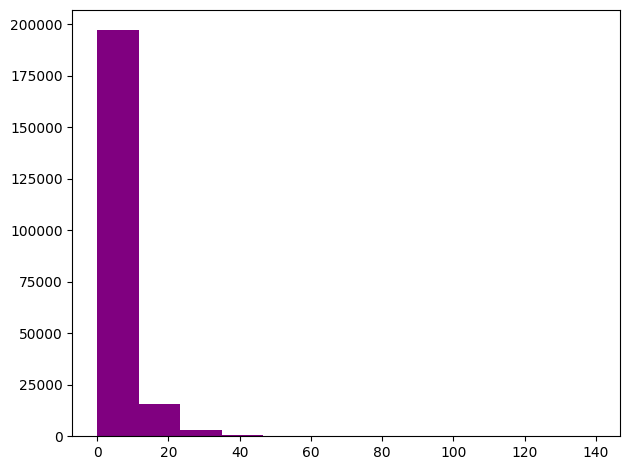

In [13]:
researh(test_group.groupby('user_id').agg({'money': 'sum'}), 'money')

Контрольная группа

Базовые метрики :
count   215,703.0
mean          3.6
std           5.2
min           0.0
25%           0.0
50%           2.0
75%           4.0
max         127.5
Name: money, dtype: float64

Медиана > 1.98

Топ 5 метриков :
money
0.0    70362
2.0    28972
4.0    18754
1.0    16502
3.0    12639
Name: count, dtype: int64

Эксцесс > 24.2101656957688
Ассиметрия > 3.579891902766202



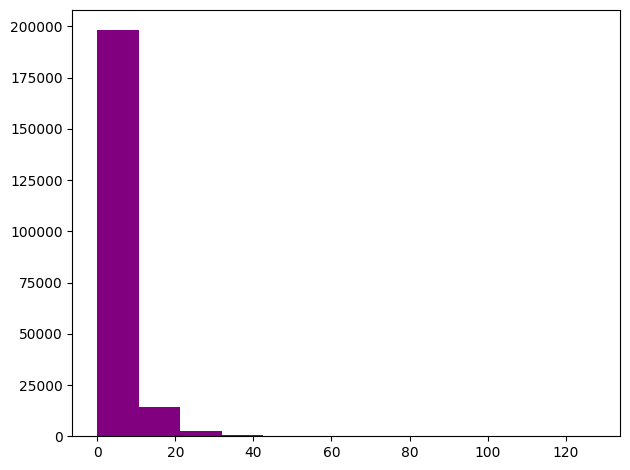

In [14]:
researh(control_group.groupby('user_id').agg({'money': 'sum'}), 'money')

In [ ]:
#Посмотрим сколько не платящих игроков во время теста
(test_group.groupby('user_id').agg({'money': 'sum'}) == 0).sum()

money    3394
dtype: int64

Теперь найдем ARPU и ARPPU

In [15]:
#Поиск суммы платежей
print(f'Сумма платежей тестовой группы > {test_group.money.sum()}')
print(f'Сумма платежей контрольной группы > {control_group.money.sum()}')

Сумма платежей тестовой группы > 833987.6600000001
Сумма платежей контрольной группы > 783245.8000000004


In [16]:
# Создаю функцию для поиска ARPU или ARPPU
def aru(df, column):
    ARU = df[column].sum() / df.drop_duplicates('user_id').count()[0]
    return ARU

In [17]:
#Поиск ARPU
ARPU_test = aru(test_group, 'money')
ARPU_control = aru(control_group, 'money')

print(f'ARPU тестовой группы > {ARPU_test}\nARPU контрольной группы > {ARPU_control}')

ARPU тестовой группы > 3.8554136540986343
ARPU контрольной группы > 3.6311307677686466


In [18]:
#Разница ARPU между тестовым и контрольной групп
print(f'ARPU тестовой группы больше контрольной на {round((ARPU_test - ARPU_control) / ARPU_control * 100)} %')

ARPU тестовой группы больше контрольной на 6 %


Теперь ищем ARPPU

In [19]:
#Отделяем платящих игроков
df = test_group.groupby('user_id').agg({'money': 'sum'}).reset_index()
test_group_paying = df[df['money'] > 0]

df = control_group.groupby('user_id').agg({'money': 'sum'}).reset_index()
control_group_paying = df[df['money'] > 0]

In [20]:
test_group_paying.groupby('user_id').agg({'money': 'sum'}).reset_index()

,user_id,money
0,000RX9-5YYMGT,6.0
1,001OMT-4LD4L3,2.0
2,001Q6Y-DAY70Y,4.0
3,0023F4-PPGTX1,2.0
4,002B9B-DZGFEU,5.9
...,...,...
150191,ZZYM21-BLPJQB,2.0
150192,ZZZ91E-MFSYMW,4.0
150193,ZZZC9G-FQ4ABS,2.0
150194,ZZZIL3-5TLJT0,5.0


Базовые метрики :
count   150,196.0
mean          5.6
std           5.8
min           1.0
25%           2.0
50%           4.0
75%           6.0
max         139.8
Name: money, dtype: float64

Медиана > 3.96

Топ 5 метриков :
money
2.0    29576
4.0    19109
1.0    16423
3.0    12571
5.9    12128
Name: count, dtype: int64

Эксцесс > 25.919203068948487
Ассиметрия > 3.6973945610790877



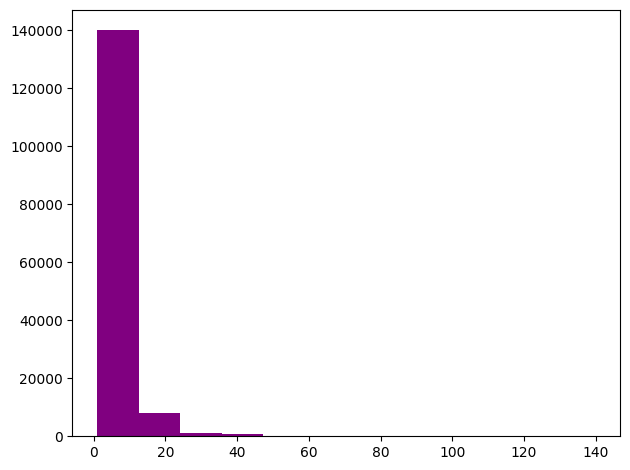

In [21]:
researh(test_group_paying, 'money')

In [22]:
control_group_paying.groupby('user_id').agg('sum').reset_index()

,user_id,money
0,00036L-1T885I,1.0
1,000F5V-PDHPGB,11.9
2,001614-WIIQ7N,4.0
3,0022XL-BUC1QH,2.0
4,002NAZ-IU2JEO,4.0
...,...,...
145336,ZZXNAU-1SZPIU,2.0
145337,ZZYV21-MZ2180,8.9
145338,ZZZNBN-SJROHK,4.0
145339,ZZZV9K-NM9B4Z,5.9


Базовые метрики :
count   145,341.0
mean          5.4
std           5.5
min           1.0
25%           2.0
50%           4.0
75%           6.0
max         127.5
Name: money, dtype: float64

Медиана > 3.96

Топ 5 метриков :
money
2.0    28972
4.0    18754
1.0    16502
3.0    12639
5.9    12339
Name: count, dtype: int64

Эксцесс > 23.23317214004225
Ассиметрия > 3.5572058151065353



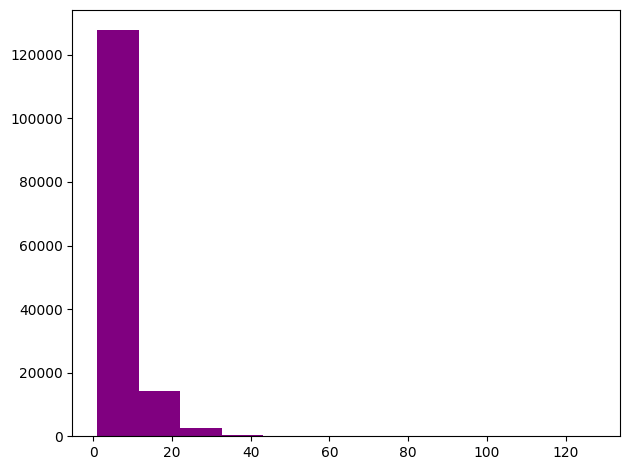

In [23]:
researh(control_group_paying, 'money')

In [24]:
#ARPPU
ARPPU_test = aru(test_group_paying, 'money')
ARPPU_control = aru(control_group_paying, 'money')
print(f'ARPPU тестовой группы > {ARPPU_test}\nARPPU контрольной группы > {ARPPU_control}')

ARPPU тестовой группы > 5.552662254653919
ARPPU контрольной группы > 5.3890216800489865


In [25]:
#Создаем функцию создании расчета доверительного интервала
def my_norm_confidence(df, column, alpha=0.95):
    interval = stats.norm.interval(alpha, loc=df[column].mean(), scale=df[column].std())
    return interval

In [26]:
test_paying_confidence = my_norm_confidence(df = test_group_paying.groupby('user_id').agg({'money': 'sum'}), column = 'money')
print(f'Доверительный интервал тестовой группы > {test_paying_confidence}')
control_paying_confidence = my_norm_confidence(df = control_group_paying.groupby('user_id').agg({'money': 'sum'}), column = 'money')
print(f'Доверительный интервал контрольной группы > {control_paying_confidence}')

Доверительный интервал тестовой группы > (-5.859513767100298, 16.964838276408138)
Доверительный интервал контрольной группы > (-5.445034998529283, 16.223078358627255)


In [27]:
#Разница ARPPU между тестовым и контрольной групп
print(f'ARPPU тестовой группы больше контрольной на {round((ARPPU_test - ARPPU_control) / ARPPU_control * 100)} %')

ARPPU тестовой группы больше контрольной на 3 %


Проверим метрики для групп разных платформ

До этого сделаем функцию для создании результата

In [28]:
def full_research(df, column = 'money', alpha = 0.95):

    df_all = df.groupby('user_id').agg({'money': 'sum'}).reset_index()
    researh(df_all, column, color = 'green', text = 'Все игроки группы')
    print('ARPU')
    print(aru(df_all, column))
    print(my_norm_confidence(df_all, column, alpha))


    dfs = df.groupby('user_id').agg({'money': 'sum'}).reset_index()  # вычленение платящих игроков (те у кого донаты больше 0)
    df_p = dfs[dfs['money'] > 0]


    print(f'\n\nМетрики платящих игроков\n')

    researh(df_p, column, color = 'blue', text = 'Платящие игроки группы')
    print('ARPPU')
    print(aru(df_p, column))
    print(my_norm_confidence(df_p, column, alpha = 0.95))

In [29]:
# Создаем метрики для групп разных платформ
test_group_PC = platforms[platforms['platform'] == 'PC'].merge(test_group, on = 'user_id')
test_group_PS4 = platforms[platforms['platform'] == 'PS4'].merge(test_group, on = 'user_id')
test_group_Xbox = platforms[platforms['platform'] == 'XBox'].merge(test_group, on = 'user_id')
control_group_PC = platforms[platforms['platform'] == 'PC'].merge(control_group, on = 'user_id')
control_group_PS4 = platforms[platforms['platform'] == 'PS4'].merge(control_group, on = 'user_id')
control_group_Xbox = platforms[platforms['platform'] == 'XBox'].merge(control_group, on = 'user_id')

Базовые метрики :
count   57,106.0
mean         7.1
std         11.5
min          0.0
25%          0.0
50%          4.0
75%          8.0
max        287.6
Name: money, dtype: float64

Медиана > 3.96

Топ 5 метриков :
money
0.0    17099
4.0     5091
2.0     5039
5.9     3834
7.9     2750
Name: count, dtype: int64

Эксцесс > 40.75774467552995
Ассиметрия > 4.623084911779709



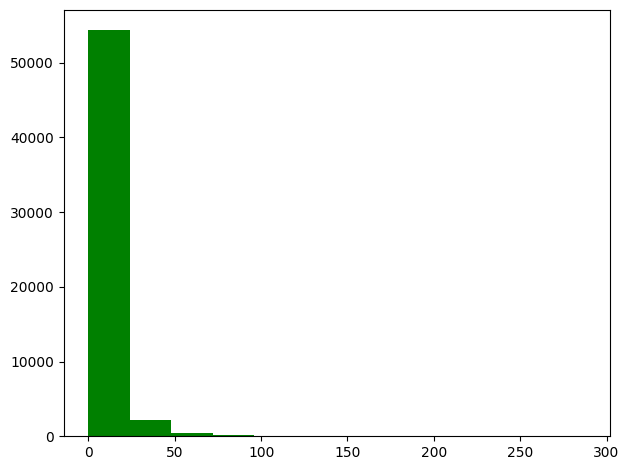

ARPU
7.054885826357999
(-15.39477732639487, 29.50454897911087)


Метрики платящих игроков

Базовые метрики :
count   40,007.0
mean        10.1
std         12.5
min          1.0
25%          3.0
50%          5.9
75%         11.9
max        287.6
Name: money, dtype: float64

Медиана > 5.9399999999999995

Топ 5 метриков :
money
4.0     5091
2.0     5039
5.9     3834
7.9     2750
11.9    2404
Name: count, dtype: int64

Эксцесс > 36.051672585751874
Ассиметрия > 4.385756605234905



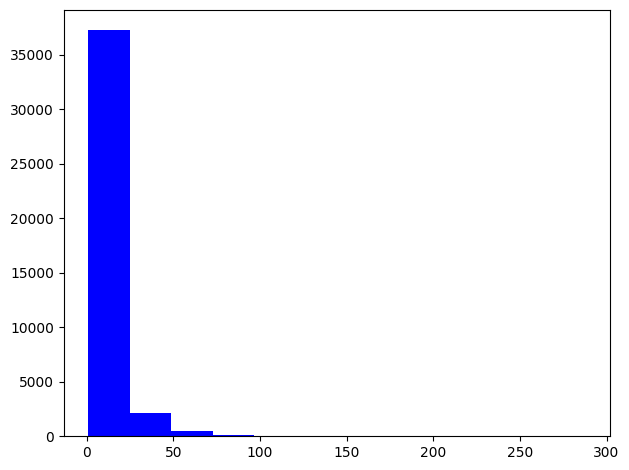

ARPPU
10.070145474541954
(-14.480856532558986, 34.62114748164289)


In [30]:
#Описание тестовой группы на PC
full_research(test_group_PC)

Базовые метрики :
count   56,899.0
mean         6.3
std         10.5
min          0.0
25%          0.0
50%          3.0
75%          7.9
max        269.5
Name: money, dtype: float64

Медиана > 2.9699999999999998

Топ 5 метриков :
money
0.0    19312
4.0     5056
2.0     5024
5.9     3759
7.9     2585
Name: count, dtype: int64

Эксцесс > 47.49912441205196
Ассиметрия > 4.847403719173894



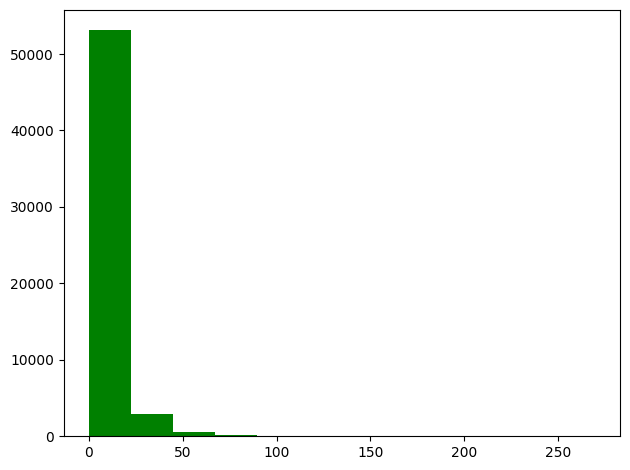

ARPU
6.280492100036907
(-14.224442351138139, 26.785426551211955)


Метрики платящих игроков

Базовые метрики :
count   37,587.0
mean         9.5
std         11.6
min          1.0
25%          3.0
50%          5.9
75%         11.9
max        269.5
Name: money, dtype: float64

Медиана > 5.9399999999999995

Топ 5 метриков :
money
4.0     5056
2.0     5024
5.9     3759
7.9     2585
11.9    2415
Name: count, dtype: int64

Эксцесс > 41.63977338661181
Ассиметрия > 4.582957497477259



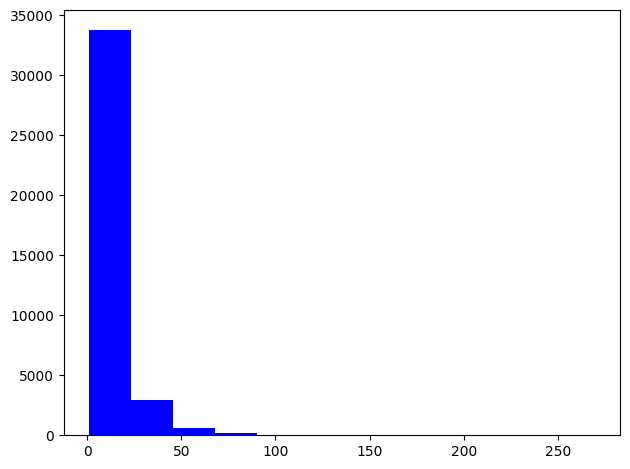

ARPPU
9.507375422353471
(-13.266035958990939, 32.28078680369788)


In [31]:
#Описание контрольной группы на PC
full_research(control_group_PC)

Базовые метрики :
count   57,043.0
mean         6.9
std         11.5
min          0.0
25%          0.0
50%          4.0
75%          8.0
max        268.2
Name: money, dtype: float64

Медиана > 3.96

Топ 5 метриков :
money
0.0    17679
4.0     5240
2.0     5027
5.9     3692
7.9     2662
Name: count, dtype: int64

Эксцесс > 43.09362785901556
Ассиметрия > 4.859728315670336



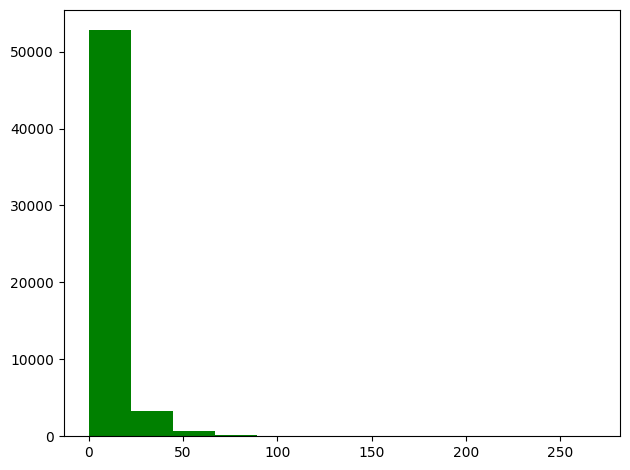

ARPU
6.873019301228898
(-15.589754299515, 29.335792901972795)


Метрики платящих игроков

Базовые метрики :
count   39,364.0
mean        10.0
std         12.6
min          1.0
25%          3.0
50%          5.9
75%         11.9
max        268.2
Name: money, dtype: float64

Медиана > 5.9399999999999995

Топ 5 метриков :
money
4.0     5240
2.0     5027
5.9     3692
7.9     2662
11.9    2509
Name: count, dtype: int64

Эксцесс > 37.363136846813454
Ассиметрия > 4.582735181165432



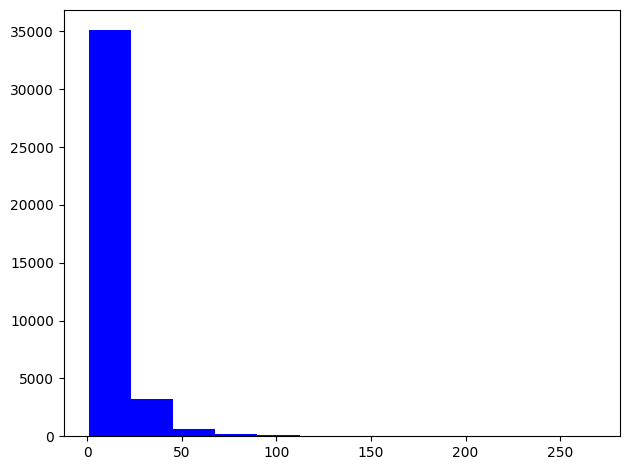

ARPPU
9.959801849405547
(-14.800879659359701, 34.720483358170796)


In [32]:
#Описание тестовой группы на PS4
full_research(test_group_PS4)

Базовые метрики :
count   57,029.0
mean         6.5
std         10.8
min          0.0
25%          0.0
50%          3.0
75%          7.9
max        238.8
Name: money, dtype: float64

Медиана > 2.98

Топ 5 метриков :
money
0.0    18804
4.0     5113
2.0     5007
5.9     3749
7.9     2676
Name: count, dtype: int64

Эксцесс > 39.21953692605175
Ассиметрия > 4.645613731415489



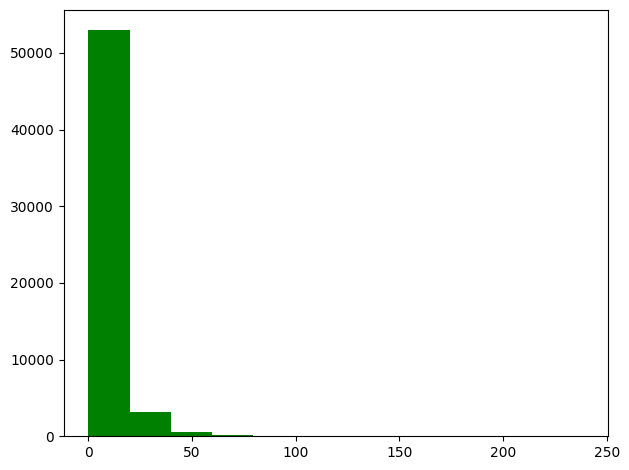

ARPU
6.50898314892423
(-14.695411030724383, 27.713377328572843)


Метрики платящих игроков

Базовые метрики :
count   38,225.0
mean         9.7
std         12.0
min          1.0
25%          3.0
50%          5.9
75%         11.9
max        238.8
Name: money, dtype: float64

Медиана > 5.9399999999999995

Топ 5 метриков :
money
4.0     5113
2.0     5007
5.9     3749
7.9     2676
11.9    2352
Name: count, dtype: int64

Эксцесс > 33.74825560174852
Ассиметрия > 4.362027750638991



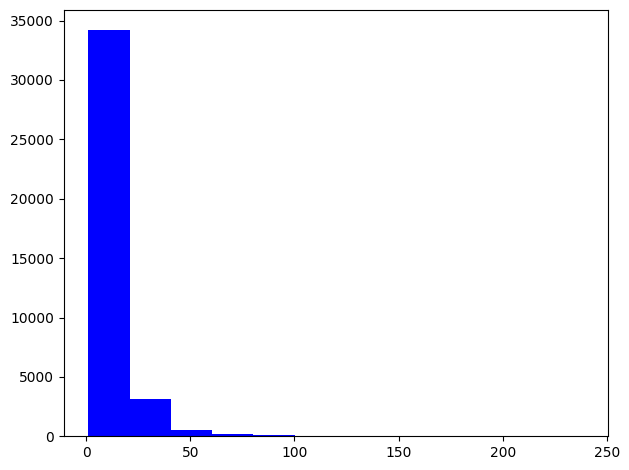

ARPPU
9.710943100065402
(-13.77025947957477, 33.192145679705575)


In [33]:
#Описание контрольной группы на PS4
full_research(control_group_PS4)

Базовые метрики :
count   57,454.0
mean         6.9
std         11.4
min          0.0
25%          0.0
50%          4.0
75%          8.0
max        449.2
Name: money, dtype: float64

Медиана > 3.96

Топ 5 метриков :
money
0.0    17711
4.0     5208
2.0     5081
5.9     3835
7.9     2657
Name: count, dtype: int64

Эксцесс > 80.87960682465821
Ассиметрия > 5.677956850303255



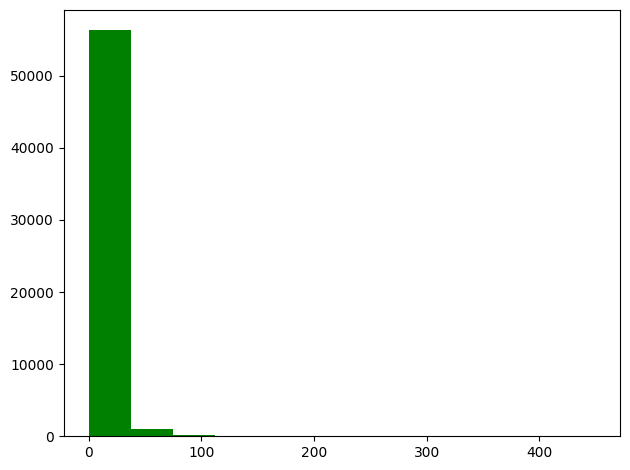

ARPU
6.858816096355345
(-15.580513262882416, 29.298145455593104)


Метрики платящих игроков

Базовые метрики :
count   39,743.0
mean         9.9
std         12.6
min          1.0
25%          3.0
50%          5.9
75%         11.9
max        449.2
Name: money, dtype: float64

Медиана > 5.9399999999999995

Топ 5 метриков :
money
4.0     5208
2.0     5081
5.9     3835
7.9     2657
11.9    2460
Name: count, dtype: int64

Эксцесс > 73.53089829247534
Ассиметрия > 5.463954348683723



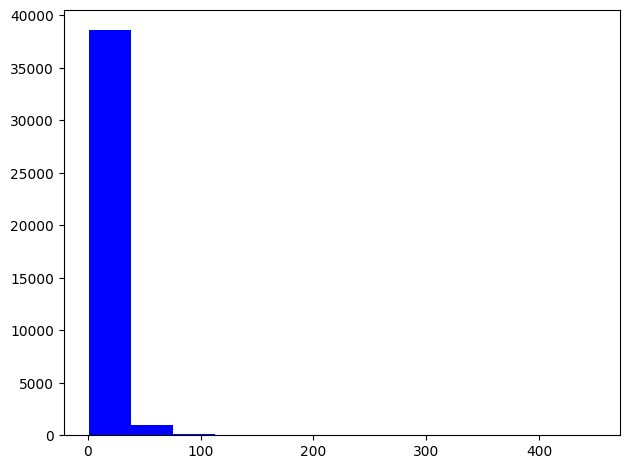

ARPPU
9.915366731248268
(-14.81302051816999, 34.643753980666524)


In [34]:
#Описание тестовой группы на Xbox
full_research(test_group_Xbox)

Базовые метрики :
count   57,364.0
mean         6.8
std         11.6
min          0.0
25%          0.0
50%          4.0
75%          8.0
max        510.1
Name: money, dtype: float64

Медиана > 3.96

Топ 5 метриков :
money
0.0    17834
4.0     5217
2.0     5047
5.9     3873
7.9     2753
Name: count, dtype: int64

Эксцесс > 107.76967801915063
Ассиметрия > 6.164070979785475



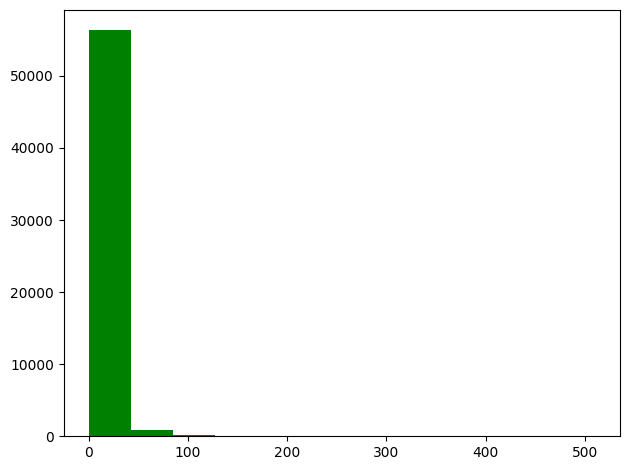

ARPU
6.842056167631267
(-15.795687843861533, 29.479800179124066)


Метрики платящих игроков

Базовые метрики :
count   39,530.0
mean         9.9
std         12.8
min          1.0
25%          3.0
50%          5.9
75%         11.9
max        510.1
Name: money, dtype: float64

Медиана > 5.9399999999999995

Топ 5 метриков :
money
4.0     5217
2.0     5047
5.9     3873
7.9     2753
11.9    2395
Name: count, dtype: int64

Эксцесс > 98.59580574591436
Ассиметрия > 5.956455876217357



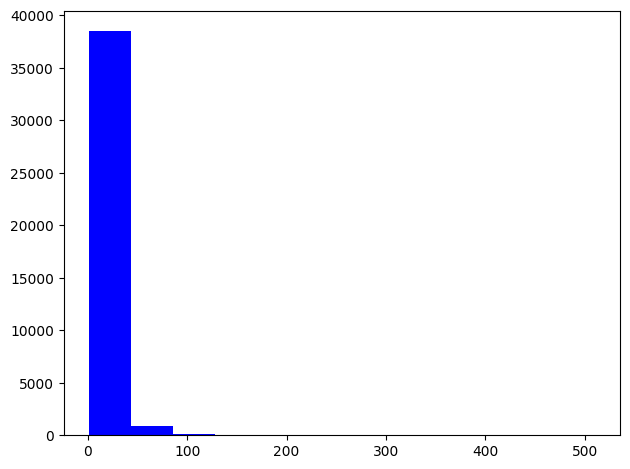

ARPPU
9.92885681760688
(-15.089855545080708, 34.947569180294465)


In [35]:
#Описание контрольной группы на Xbox
full_research(control_group_Xbox)

Раздел 5. Формирование отчета

ARPU = трата валюты / кол-во игроков

ARPPU = трата валюты / кол-во платящих игроков


Создадим функцию, похожую на предыдущего

In [36]:
def basic_metrics(df, column):
    print(f"Базовые метрики - все игроки\n")
    print(df[column].describe())
    print(f'\nМедиана > {df[column].median()}')

    print("Самые популярные значения метрики, топ 5")
    print(df[column].value_counts().nlargest(5))

    print(f"Эксцесс > {kurtosis(df[column])}")
    print(f"Ассиметрия > {skew(df[column])}")

    print(f'Сумма > {df[column].sum()}')
    ARSU = df[column].sum() / df.drop_duplicates('user_id').count()[0]
    print(f'ARSU > {ARSU}')

    return df

def confidence_interval(df, column, alpha):
    interval = stats.norm.interval(alpha, loc=df[column].mean(), scale=df[column].std())
    print(f'Доверительный интервал средней: {interval}\n\n')

def plot_histogram(df, column, title):
    plot = sns.histplot(df[column], color='green', bins=40)
    plot.set_title(title)
    plt.show()

def all_research(df, column='money', alpha=0.95, plot_type='hist'):
    df_all = df.groupby('user_id').agg({column: 'sum'}).reset_index()
    df_p = df_all[df_all[column] > 0]

    df_all_basic = basic_metrics(df_all, column)
    confidence_interval(df_all_basic, column, alpha)

    if plot_type == 'hist':
        plot_histogram(df_all, column, 'Все игроки')

    df_p_basic = basic_metrics(df_p, column)
    confidence_interval(df_p_basic, column, alpha)

    if plot_type == 'hist':
        plot_histogram(df_p, column, 'Платящие игроки')

In [37]:
#Датафреймы с тратой валюты
test_group = test_group.merge(cash, on=['user_id', 'date'])
control_group = control_group.merge(cash, on=['user_id', 'date'])

In [38]:
test_group.head()

,user_id,cheaters,group,date,money,cash
0,S2VBV4-ZKBHI6,0.0,test,12.07.2021,0.0,800.0
1,S2VBV4-ZKBHI6,0.0,test,12.07.2021,0.0,800.0
2,S2VBV4-ZKBHI6,0.0,test,12.07.2021,0.0,800.0
3,S2VBV4-ZKBHI6,0.0,test,12.07.2021,0.0,800.0
4,S2VBV4-ZKBHI6,0.0,test,12.07.2021,0.0,800.0


Базовые метрики - все игроки

count   35,769.0
mean     2,777.4
std      3,709.4
min          0.0
25%        600.0
50%      1,600.0
75%      3,600.0
max     84,000.0
Name: cash, dtype: float64

Медиана > 1600.0
Самые популярные значения метрики, топ 5
cash
0.0        4392
1,200.0     886
600.0       877
900.0       793
2,400.0     705
Name: count, dtype: int64
Эксцесс > 37.739851363583725
Ассиметрия > 4.294609830157565
Сумма > 99344650.0
ARSU > 2777.3952305068633
Доверительный интервал средней: (-4492.930353089859, 10047.720814103584)




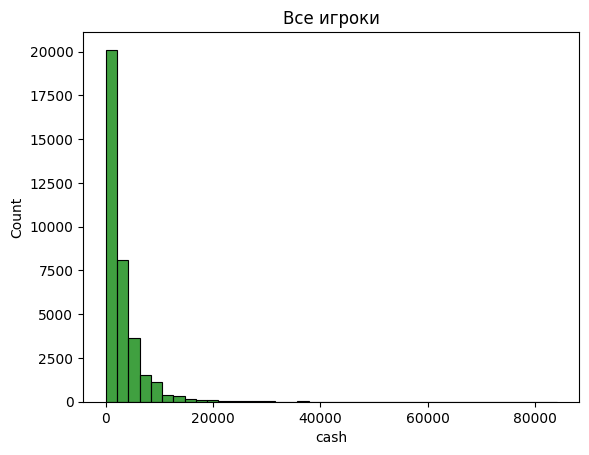

Базовые метрики - все игроки

count   31,377.0
mean     3,166.2
std      3,802.0
min         50.0
25%        950.0
50%      2,000.0
75%      4,000.0
max     84,000.0
Name: cash, dtype: float64

Медиана > 2000.0
Самые популярные значения метрики, топ 5
cash
1,200.0    886
600.0      877
900.0      793
2,400.0    705
1,800.0    695
Name: count, dtype: int64
Эксцесс > 37.22432583228584
Ассиметрия > 4.293627985225211
Сумма > 99344650.0
ARSU > 3166.161519584409
Доверительный интервал средней: (-4285.551999258063, 10617.87503842688)




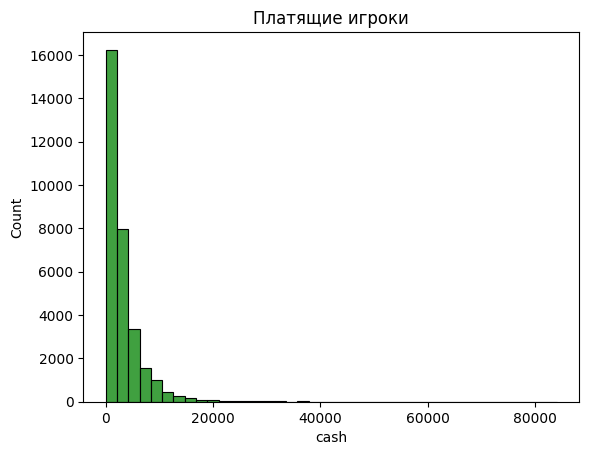

In [39]:
#Тестовая группа
all_research(test_group, 'cash')

Базовые метрики - все игроки

count   35,812.0
mean     2,558.8
std      3,330.0
min          0.0
25%        500.0
50%      1,500.0
75%      3,300.0
max     81,000.0
Name: cash, dtype: float64

Медиана > 1500.0
Самые популярные значения метрики, топ 5
cash
0.0        4636
1,200.0     910
600.0       879
900.0       788
1,800.0     777
Name: count, dtype: int64
Эксцесс > 37.371874851566716
Ассиметрия > 4.0195504490355045
Сумма > 91634250.0
ARSU > 2558.758237462303
Доверительный интервал средней: (-3967.894075907326, 9085.410550831932)




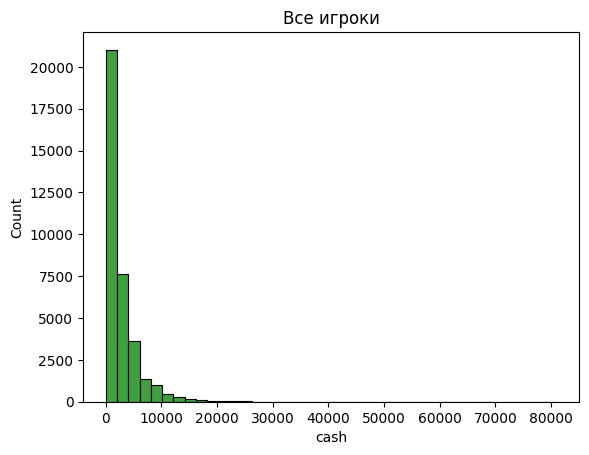

Базовые метрики - все игроки

count   31,176.0
mean     2,939.3
std      3,408.7
min         50.0
25%        900.0
50%      1,900.0
75%      3,750.0
max     81,000.0
Name: cash, dtype: float64

Медиана > 1900.0
Самые популярные значения метрики, топ 5
cash
1,200.0    910
600.0      879
900.0      788
1,800.0    777
300.0      743
Name: count, dtype: int64
Эксцесс > 37.31489118501464
Ассиметрия > 4.031305243248408
Сумма > 91634250.0
ARSU > 2939.2561585835256
Доверительный интервал средней: (-3741.7183202396955, 9620.230637406747)




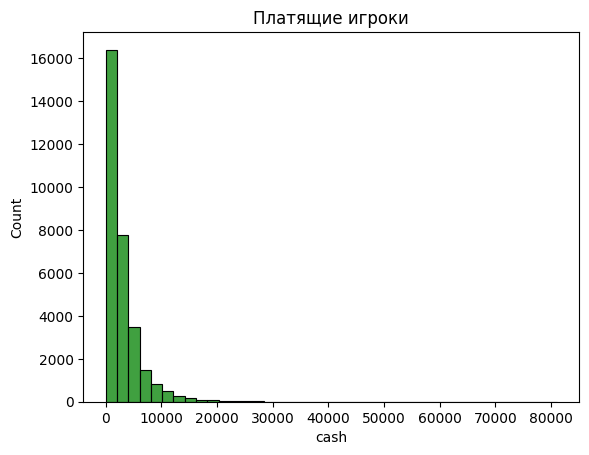

In [40]:
all_research(control_group, 'cash')

In [41]:
#Добавим столбцы cash в датафреймы с платформами
test_group_PC = test_group_PC.merge(cash, on = ['user_id'])
test_group_PS4 = test_group_PS4.merge(cash, on = ['user_id'])
test_group_Xbox = test_group_Xbox.merge(cash, on = ['user_id'])
control_group_PC = control_group_PC.merge(cash, on = ['user_id'])
control_group_PS4 = control_group_PS4.merge(cash, on = ['user_id'])
control_group_Xbox = control_group_Xbox.merge(cash, on = ['user_id'])

Базовые метрики - все игроки

count      36,095.0
mean       10,905.8
std        21,299.8
min             0.0
25%         1,800.0
50%         5,100.0
75%        12,300.0
max     1,146,400.0
Name: cash, dtype: float64

Медиана > 5100.0
Самые популярные значения метрики, топ 5
cash
0.0        3224
2,400.0     625
3,600.0     582
4,800.0     562
1,200.0     544
Name: count, dtype: int64
Эксцесс > 471.2947403998999
Ассиметрия > 14.07503066064587
Сумма > 393643350.0
ARSU > 10905.758415292978
Доверительный интервал средней: (-30841.04853018233, 52652.56536076828)




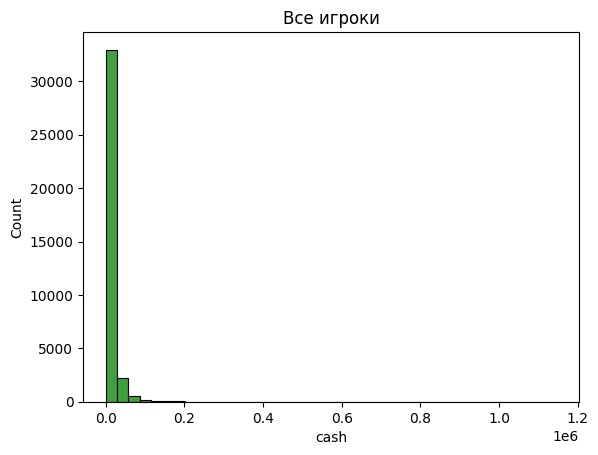

Базовые метрики - все игроки

count      32,871.0
mean       11,975.4
std        22,031.1
min            50.0
25%         2,500.0
50%         6,000.0
75%        13,500.0
max     1,146,400.0
Name: cash, dtype: float64

Медиана > 6000.0
Самые популярные значения метрики, топ 5
cash
2,400.0    625
3,600.0    582
4,800.0    562
1,200.0    544
1,800.0    539
Name: count, dtype: int64
Эксцесс > 449.3239599380278
Ассиметрия > 13.83309142384759
Сумма > 393643350.0
ARSU > 11975.399288126311
Доверительный интервал средней: (-31204.769482017524, 55155.568058270146)




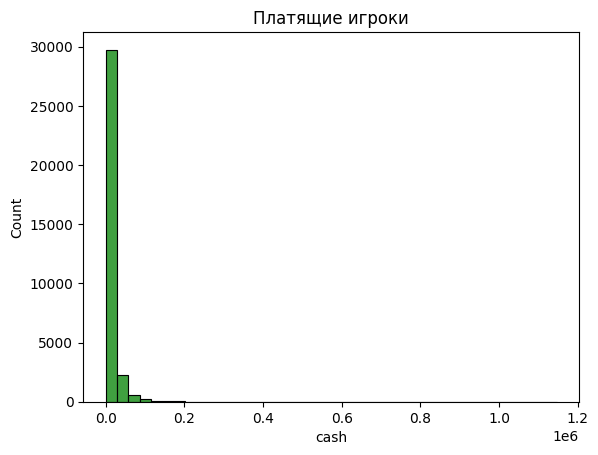

In [42]:
all_research(test_group_PC, 'cash')

Базовые метрики - все игроки

count      35,789.0
mean        9,567.9
std        22,796.1
min             0.0
25%         1,500.0
50%         4,500.0
75%        10,800.0
max     2,870,400.0
Name: cash, dtype: float64

Медиана > 4500.0
Самые популярные значения метрики, топ 5
cash
0.0        3337
2,400.0     673
1,200.0     647
3,600.0     608
4,800.0     567
Name: count, dtype: int64
Эксцесс > 6986.600338056464
Ассиметрия > 58.93035949245595
Сумма > 342425000.0
ARSU > 9567.883986699824
Доверительный интервал средней: (-35111.74826873649, 54247.51624213614)




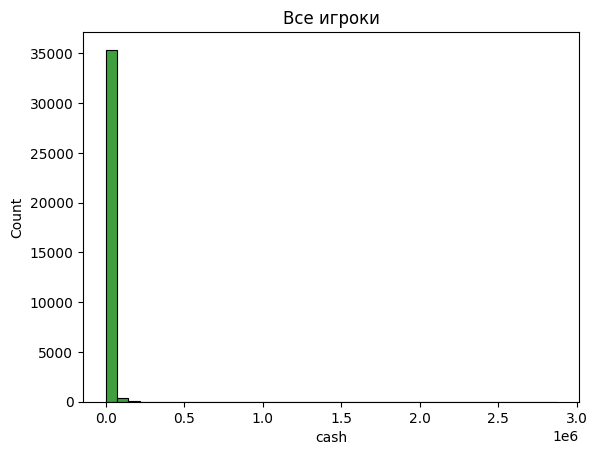

Базовые метрики - все игроки

count      32,452.0
mean       10,551.7
std        23,721.7
min            50.0
25%         2,200.0
50%         5,400.0
75%        12,000.0
max     2,870,400.0
Name: cash, dtype: float64

Медиана > 5400.0
Самые популярные значения метрики, топ 5
cash
2,400.0    673
1,200.0    647
3,600.0    608
4,800.0    567
1,800.0    556
Name: count, dtype: int64
Эксцесс > 6561.335012008875
Ассиметрия > 57.55810343538627
Сумма > 342425000.0
ARSU > 10551.737951435967
Доверительный интервал средней: (-35942.01453856568, 57045.49044143761)




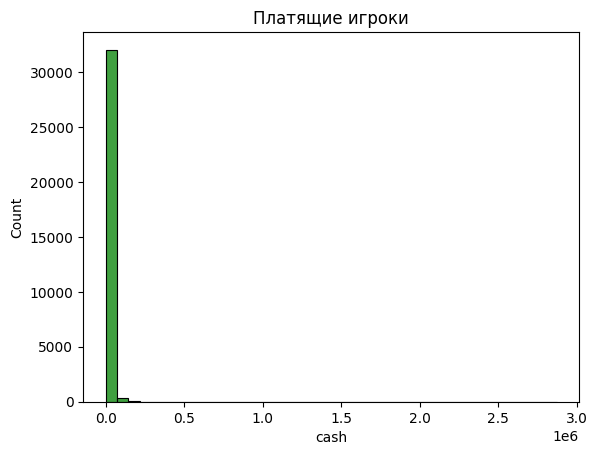

In [43]:
all_research(control_group_PC, 'cash')

Базовые метрики - все игроки

count    36,017.0
mean     10,232.7
std      17,758.5
min           0.0
25%       1,700.0
50%       4,800.0
75%      12,000.0
max     648,000.0
Name: cash, dtype: float64

Медиана > 4800.0
Самые популярные значения метрики, топ 5
cash
0.0        3029
2,400.0     654
1,200.0     632
1,800.0     559
3,000.0     550
Name: count, dtype: int64
Эксцесс > 131.7603422627017
Ассиметрия > 7.585661456156252
Сумма > 368552750.0
ARSU > 10232.744259655163
Доверительный интервал средней: (-24573.32896775433, 45038.817487064654)




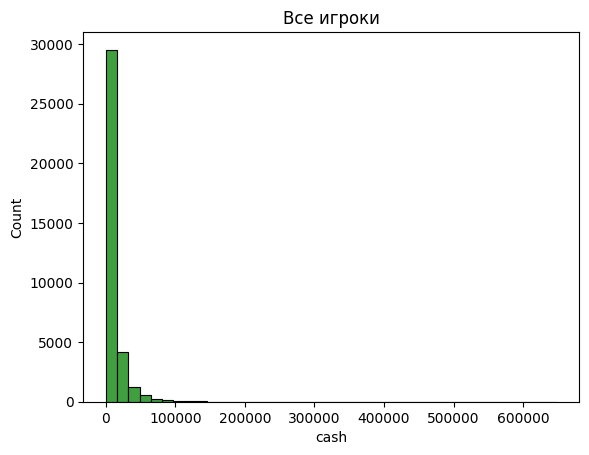

Базовые метрики - все игроки

count    32,988.0
mean     11,172.3
std      18,270.9
min          50.0
25%       2,400.0
50%       5,600.0
75%      12,800.0
max     648,000.0
Name: cash, dtype: float64

Медиана > 5600.0
Самые популярные значения метрики, топ 5
cash
2,400.0    654
1,200.0    632
1,800.0    559
3,000.0    550
3,600.0    544
Name: count, dtype: int64
Эксцесс > 126.75106750606778
Ассиметрия > 7.466516281743932
Сумма > 368552750.0
ARSU > 11172.327816175579
Доверительный интервал средней: (-24637.97581152167, 46982.63144387283)




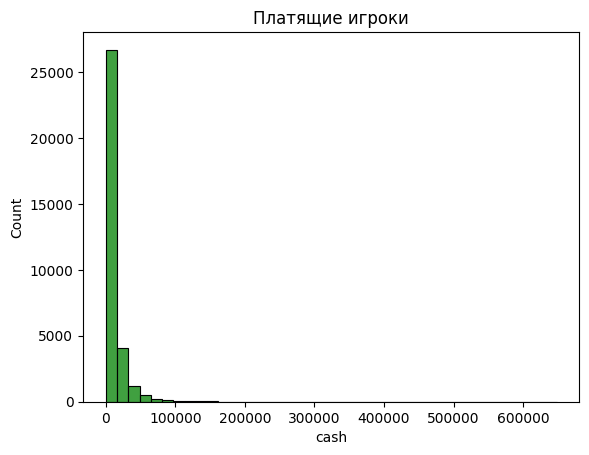

In [44]:
all_research(test_group_PS4, 'cash')

Базовые метрики - все игроки

count    35,895.0
mean      9,586.1
std      16,419.1
min           0.0
25%       1,600.0
50%       4,500.0
75%      10,800.0
max     549,000.0
Name: cash, dtype: float64

Медиана > 4500.0
Самые популярные значения метрики, топ 5
cash
0.0        3259
2,400.0     647
3,600.0     619
1,200.0     613
1,800.0     579
Name: count, dtype: int64
Эксцесс > 104.81112611549453
Ассиметрия > 6.70157121337122
Сумма > 344093250.0
ARSU > 9586.105307145843
Доверительный интервал средней: (-22594.705778788273, 41766.916393079955)




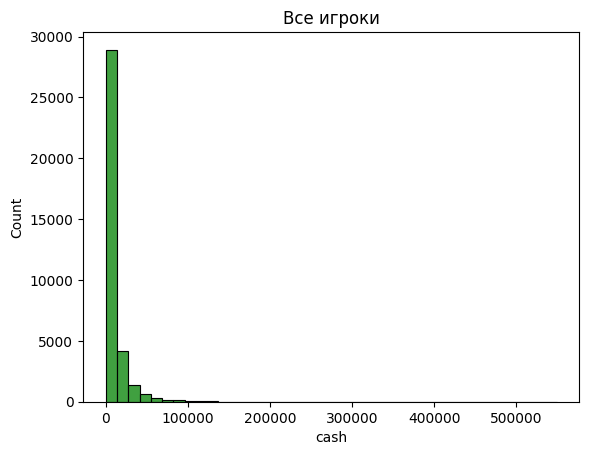

Базовые метрики - все игроки

count    32,636.0
mean     10,543.4
std      16,923.8
min          50.0
25%       2,250.0
50%       5,200.0
75%      12,000.0
max     549,000.0
Name: cash, dtype: float64

Медиана > 5200.0
Самые популярные значения метрики, топ 5
cash
2,400.0    647
3,600.0    619
1,200.0    613
1,800.0    579
4,800.0    564
Name: count, dtype: int64
Эксцесс > 100.53484818132227
Ассиметрия > 6.579115473455565
Сумма > 344093250.0
ARSU > 10543.364689300159
Доверительный интервал средней: (-22626.65567705853, 43713.385055658844)




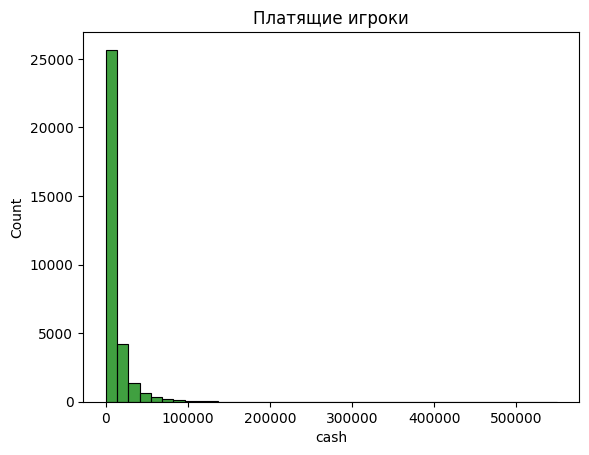

In [45]:
all_research(control_group_PS4, 'cash')

Базовые метрики - все игроки

count    35,975.0
mean     10,208.1
std      17,646.2
min           0.0
25%       1,700.0
50%       4,800.0
75%      11,600.0
max     428,000.0
Name: cash, dtype: float64

Медиана > 4800.0
Самые популярные значения метрики, топ 5
cash
0.0        3049
2,400.0     640
3,600.0     634
1,200.0     631
1,800.0     545
Name: count, dtype: int64
Эксцесс > 63.662990285803204
Ассиметрия > 6.015759194793801
Сумма > 367236450.0
ARSU > 10208.101459346768
Доверительный интервал средней: (-24377.89039260462, 44794.09331129816)




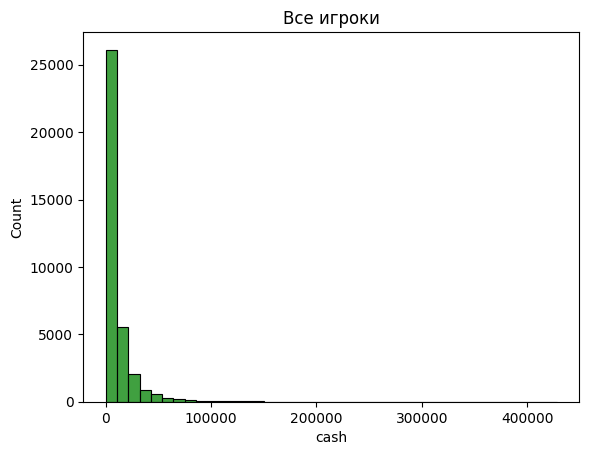

Базовые метрики - все игроки

count    32,926.0
mean     11,153.4
std      18,157.2
min          50.0
25%       2,400.0
50%       5,600.0
75%      12,600.0
max     428,000.0
Name: cash, dtype: float64

Медиана > 5600.0
Самые популярные значения метрики, топ 5
cash
2,400.0    640
3,600.0    634
1,200.0    631
1,800.0    545
3,000.0    521
Name: count, dtype: int64
Эксцесс > 60.72510885729894
Ассиметрия > 5.893594785259294
Сумма > 367236450.0
ARSU > 11153.387900139707
Доверительный интервал средней: (-24433.984562244106, 46740.76036252352)




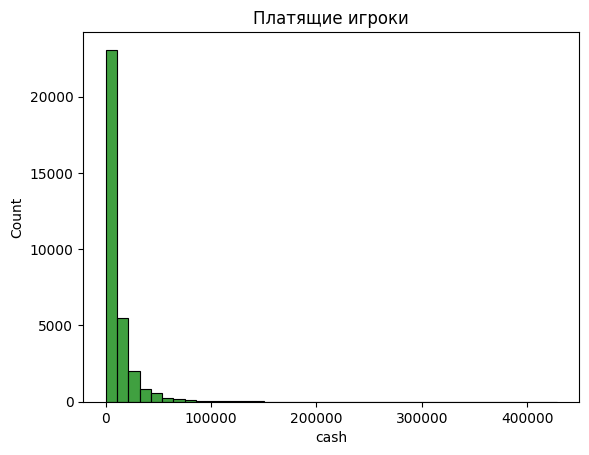

In [46]:
all_research(test_group_Xbox, 'cash')

Базовые метрики - все игроки

count    36,305.0
mean     10,291.6
std      18,054.4
min           0.0
25%       1,700.0
50%       4,800.0
75%      11,700.0
max     500,000.0
Name: cash, dtype: float64

Медиана > 4800.0
Самые популярные значения метрики, топ 5
cash
0.0        3133
2,400.0     638
1,200.0     628
3,600.0     566
1,800.0     546
Name: count, dtype: int64
Эксцесс > 79.41359027471367
Ассиметрия > 6.519095580015831
Сумма > 373637250.0
ARSU > 10291.619611623742
Доверительный интервал средней: (-25094.257927633502, 45677.49715088098)




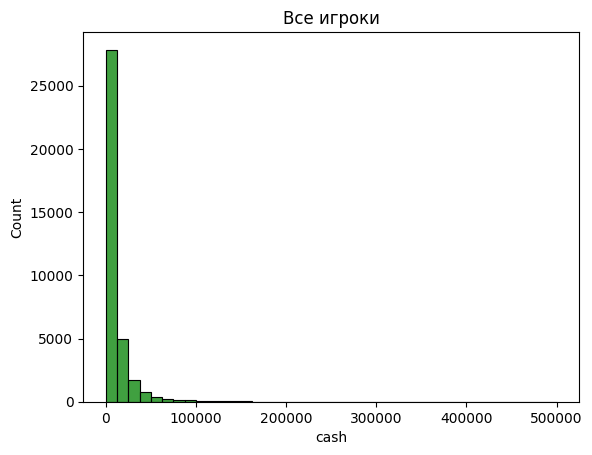

Базовые метрики - все игроки

count    33,172.0
mean     11,263.6
std      18,595.6
min          50.0
25%       2,400.0
50%       5,600.0
75%      12,600.0
max     500,000.0
Name: cash, dtype: float64

Медиана > 5600.0
Самые популярные значения метрики, топ 5
cash
2,400.0    638
1,200.0    628
3,600.0    566
1,800.0    546
4,800.0    536
Name: count, dtype: int64
Эксцесс > 75.78441871940637
Ассиметрия > 6.388798663143304
Сумма > 373637250.0
ARSU > 11263.633486072591
Доверительный интервал средней: (-25183.145657850575, 47710.41262999576)




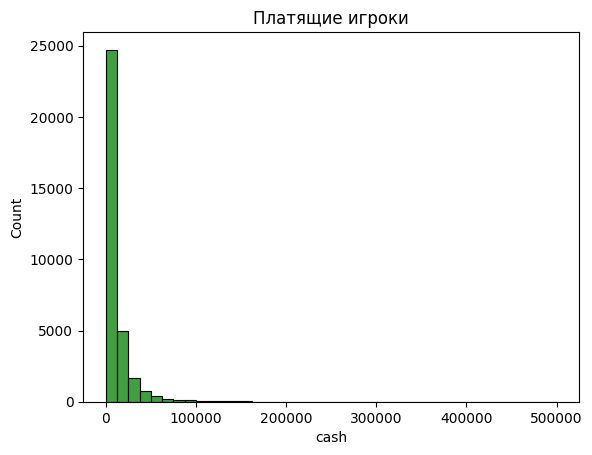

In [47]:
all_research(control_group_Xbox, 'cash')

In [48]:
control_group.head()

,user_id,cheaters,group,date,money,cash
0,BUWZRF-PUE7SE,0.0,control,17.07.2021,2.0,"1,400.0"
1,OWQ27T-TSRIMD,0.0,control,17.07.2021,0.0,0.0
2,OWQ27T-TSRIMD,0.0,control,17.07.2021,0.0,0.0
3,WWCOOB-IGMMEE,0.0,control,13.07.2021,0.0,250.0
4,WWCOOB-IGMMEE,0.0,control,13.07.2021,0.0,250.0


Подготовим датафрейм который позже преобразуем в csv для PowerBI, в нем должны быть столбцы с нашими метриками по дням.

In [49]:
powerbi_test = test_group.groupby('date').agg({'money':'sum', 'cash':'sum'})
powerbi_test['users'] = test_group.groupby('date').agg('count')['user_id'][1]
df = test_group.groupby('user_id').agg({'money':'sum'}).reset_index()
df = df[df['money'] > 0]
df = pd.DataFrame(df.drop(columns=['money']).merge(money, on = 'user_id').merge(cash, on = ['user_id', 'date']).groupby('date').agg('count')['user_id'].reset_index())
df.rename(columns={'user_id' : 'paying_users'}, inplace=True)
powerbi_test = df[['date', 'paying_users']].merge(powerbi_test, on='date')

In [50]:
powerbi_test.head()

,date,paying_users,money,cash,users
0,10.07.2021,2954,"11,813.5","12,500,800.0",15884
1,11.07.2021,3055,"12,208.6","13,149,150.0",15884
2,12.07.2021,3055,"12,228.4","13,150,100.0",15884
3,13.07.2021,2976,"12,089.7","12,785,050.0",15884
4,14.07.2021,2928,"11,249.7","11,952,550.0",15884


In [51]:
powerbi_test['ARPU'] = powerbi_test['money'] / powerbi_test['users']
powerbi_test['ARPPU'] = powerbi_test['money'] / powerbi_test['paying_users']
powerbi_test['ARSU'] = powerbi_test['cash'] / powerbi_test['users']
powerbi_test['ARSPU'] = powerbi_test['cash'] / powerbi_test['paying_users']
powerbi_test

,date,paying_users,money,cash,users,ARPU,ARPPU,ARSU,ARSPU
0,10.07.2021,2954,"11,813.5","12,500,800.0",15884,0.7,4.0,787.0,"4,231.8"
1,11.07.2021,3055,"12,208.6","13,149,150.0",15884,0.8,4.0,827.8,"4,304.1"
2,12.07.2021,3055,"12,228.4","13,150,100.0",15884,0.8,4.0,827.9,"4,304.5"
3,13.07.2021,2976,"12,089.7","12,785,050.0",15884,0.8,4.1,804.9,"4,296.1"
4,14.07.2021,2928,"11,249.7","11,952,550.0",15884,0.7,3.8,752.5,"4,082.2"
5,15.07.2021,2707,"10,507.5","10,525,850.0",15884,0.7,3.9,662.7,"3,888.4"
6,16.07.2021,2467,"8,801.0","8,245,400.0",15884,0.6,3.6,519.1,"3,342.3"
7,17.07.2021,2991,"19,588.2","17,035,750.0",15884,1.2,6.5,"1,072.5","5,695.7"


In [52]:
powerbi_test.to_excel('powerbi_test.xlsx', index=False)

In [53]:
powerbi_control = control_group.groupby('date').agg({'money':'sum', 'cash':'sum'})
powerbi_control['users'] = control_group.groupby('date').agg('count')['user_id'][1]
df = control_group.groupby('user_id').agg({'money':'sum'}).reset_index()
df = df[df['money'] > 0]
df = pd.DataFrame(df.drop(columns=['money']).merge(money, on = 'user_id').merge(cash, on = ['user_id', 'date']).groupby('date').agg('count')['user_id'].reset_index())
df.rename(columns={'user_id' : 'paying_users'}, inplace=True)
powerbi_control = df[['date', 'paying_users']].merge(powerbi_control, on='date')

In [54]:
powerbi_control['ARPU'] = powerbi_control['money'] / powerbi_control['users']
powerbi_control['ARPPU'] = powerbi_control['money'] / powerbi_control['paying_users']
powerbi_control['ARSU'] = powerbi_control['cash'] / powerbi_control['users']
powerbi_control['ARSPU'] = powerbi_control['cash'] / powerbi_control['paying_users']
powerbi_control

,date,paying_users,money,cash,users,ARPU,ARPPU,ARSU,ARSPU
0,10.07.2021,2884,"11,338.7","12,112,700.0",15723,0.7,3.9,770.4,"4,200.0"
1,11.07.2021,2871,"11,209.3","12,019,450.0",15723,0.7,3.9,764.5,"4,186.5"
2,12.07.2021,2990,"11,732.9","12,116,050.0",15723,0.7,3.9,770.6,"4,052.2"
3,13.07.2021,2891,"11,051.8","11,639,150.0",15723,0.7,3.8,740.3,"4,026.0"
4,14.07.2021,2777,"10,555.0","10,986,900.0",15723,0.7,3.8,698.8,"3,956.4"
5,15.07.2021,2621,"9,917.8","9,880,650.0",15723,0.6,3.8,628.4,"3,769.8"
6,16.07.2021,2434,"9,025.9","8,069,800.0",15723,0.6,3.7,513.2,"3,315.4"
7,17.07.2021,2852,"16,975.8","14,809,550.0",15723,1.1,6.0,941.9,"5,192.7"


In [55]:
powerbi_control.to_excel('powerbi_control.xlsx', index=False)

Теперь подготовим Excel файл для сводной таблицы ARPU по группам и платформам. Для этого нужна таблица с количеством игроков, их платформой, группой, и суммарным платежом за период.

In [56]:
excel = money.groupby('user_id').agg({'money':'sum'}).reset_index().merge(platforms, on='user_id').merge(players, on='user_id').drop(columns='cheaters')

df = excel.groupby(['platform', 'group']).agg('sum').reset_index()
df = df.merge(excel.groupby(['platform', 'group']).agg('count').reset_index()[['user_id', 'platform', 'group']], on=['platform', 'group'])

df.rename(columns={'user_id' : 'users'}, inplace=True)

df.to_excel('table.xlsx')